<a href="https://colab.research.google.com/github/SnazzyBeatle115/UG54/blob/main/chapters/Assignments/Assignment4_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Please write your name below
David Shen
ds6870@nyu.edu

In this assignment we explore different portfolio allocation rules applied to the Fama-French five-factor model.

The five factors are excess-return portfolios:

| Factor | Long | Short |
|--------|------|-------|
| **Mkt-RF** | Market | Risk-free rate |
| **SMB** | Small caps | Large caps |
| **HML** | High book-to-market (value) | Low book-to-market (growth) |
| **RMW** | High profitability | Low profitability |
| **CMA** | Low investment | High investment |

Each factor is already an **excess return** (no need to subtract rf again). Returns are in **percent** (5% appears as 5, not 0.05).

---

# Exercises

**Exercise 1 — Import the data**

Download the Fama-French 5-factor monthly returns from Ken French's website via `pandas_datareader`.

```python
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
datasets = get_available_datasets()   # inspect this list to find the right name
ds = web.DataReader(<name>, 'famafrench')
df = ds[0]   # ds is a dict; key 0 is the monthly table
```

Steps:
1. Import `pandas`, `numpy`, `matplotlib`, and `pandas_datareader`.
2. Load the monthly 5-factor dataset. The result should have 6 columns: `Mkt-RF`, `SMB`, `HML`, `RMW`, `CMA`, `RF`.
3. Convert the index to `datetime` using `.to_timestamp()`.
4. Confirm by calling `df.head()`.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web

# your code below
from pandas_datareader.famafrench import get_available_datasets
datasets = get_available_datasets()   # inspect this list to find the right name
ds = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench')
df = ds[0]   # ds is a dict; key 0 is the monthly table
df.index = df.index.to_timestamp()
df.head()

/tmp/ipython-input-2251/2485045721.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ds = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench')
/tmp/ipython-input-2251/2485045721.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ds = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench')


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2021-02-01,2.81,4.50,7.20,0.33,-1.99,0.0
2021-03-01,3.16,-0.84,7.35,6.35,3.52,0.0
2021-04-01,4.97,-3.16,-1.02,2.43,-2.72,0.0
2021-05-01,0.29,1.27,7.04,2.34,3.01,0.0
2021-06-01,2.73,-0.30,-7.86,-2.14,-0.93,0.0


**Exercise 2 — Mean-Variance Efficient (MVE) portfolio**

The portfolio that maximises the Sharpe ratio has weights proportional to

$$w^{\text{MVE}} \propto \Sigma^{-1} \mu$$

where $\mu$ is the vector of expected excess returns and $\Sigma$ is the covariance matrix — both estimated from the full sample.

Steps:
1. Estimate $\mu$ (`ERe`) as the sample mean of each factor.
2. Estimate $\Sigma$ (`CovRe`) using `.cov()`.
3. Compute the **raw** weights: `raw = np.linalg.inv(CovRe) @ ERe`.
4. **Normalise** so they sum to 1: divide by `raw.sum()`. Call these `w_mve`.
5. **Leverage** the normalised weights so the portfolio's in-sample annualised volatility matches the in-sample annualised volatility of the market factor (`Mkt-RF`).
   - Portfolio monthly variance: $w^T \Sigma w$
   - Market monthly variance: `df['Mkt-RF'].var()`
   - Required leverage: $x = \sigma_{\text{mkt}} / \sigma_{\text{mve}}$
   - Levered weights: $W = x \cdot w^{\text{mve}}$
6. Report the weights and the in-sample Sharpe Ratio of the levered portfolio.

Store the levered weights in a Series or DataFrame column called `mve`.

In [38]:
# your code below
factors = ['Mkt-RF','SMB','HML','RMW','CMA']


# 1-2. Sample moments
ERe   = df[factors].mean()
CovRe = df[factors].cov()

print(ERe)
print(CovRe)


# 3. Raw MVE weights
raw_weights = np.linalg.inv(CovRe) @ ERe
# print(raw_weights)

# 4. Normalise to sum to 1
w_mve = raw_weights / raw_weights.sum()

# 5. Leverage to match market vol
sigma_mkt =   df['Mkt-RF'].std() * 12**0.5
sigma_mve =   (w_mve @ CovRe @ w_mve)**0.5 * 12**0.5
x         =   sigma_mkt / sigma_mve
W_mve     = x * w_mve      # these are the final weights

# 6. In-sample Sharpe Ratio
port_returns =    W_mve @ df[factors].T
SR_mve       =   (12 * port_returns.mean()) / sigma_mkt

print("Weights:\n", W_mve)
print(f"\nIn-sample SR: {SR_mve:.3f}")

Mkt-RF    0.884407
SMB      -0.511525
HML       0.622203
RMW       0.555424
CMA       0.034746
dtype: float64
           Mkt-RF       SMB        HML       RMW       CMA
Mkt-RF  19.915601  2.704472  -3.132206 -1.099383 -3.147416
SMB      2.704472  8.826720   3.872567 -2.601297 -0.092855
HML     -3.132206  3.872567  18.233331  2.235817  9.086358
RMW     -1.099383 -2.601297   2.235817  7.167046  2.405429
CMA     -3.147416 -0.092855   9.086358  2.405429  9.020601
Weights:
 [ 0.62946807 -1.14092208  1.13402665  0.42209886 -1.00945733]

In-sample SR: 1.588


**Exercise 3 — Choosing leverage**

The composition of the MVE portfolio (i.e., the **relative** weights across factors) is fixed by the ratio $\Sigma^{-1}\mu$.  
Leverage is a **separate** decision that scales all weights up or down without changing the portfolio's Sharpe ratio.

Use the **unit-normalised** weights `w_mve` from Exercise 2 as your starting point.  
In this exercise you choose different values of the scalar $x$ to hit specific targets.

---

**3a. Target a 10% annual expected excess return**

The portfolio's expected excess return (annualised, in percent) is

$$E[R^e_p]^{\text{ann}} = 12 \times x \cdot w^{\text{mve}\top} \mu$$

Set this equal to 10 (remember returns are in percent) and solve for $x$.

Report the weights and the annualised expected excess return. Verify it equals 10%.

---

**3b. Target a 10% annual volatility**

The portfolio's annualised volatility is

$$\sigma_p^{\text{ann}} = \sqrt{12} \times x \times \sqrt{w^{\text{mve}\top} \Sigma\, w^{\text{mve}}}$$

Set this equal to 10 (percent) and solve for $x$.

Report the weights and verify the annualised vol equals 10%.

---

**3c. Target a 10% annual *total* expected return**

The total (not excess) expected return is

$$E[R_p]^{\text{ann}} = 12 \times rf + E[R^e_p]^{\text{ann}}$$

To hit a 10% total return target you also need an estimate of the risk-free rate $rf$.

- Use the average monthly `RF` from your data and annualise it.
- Solve for $x$ such that $12 \times rf + 12 \times x \cdot w^{\text{mve}\top}\mu = 10$.
- Report the weights and discuss: why does targeting a total return require more information than targeting an excess return?

---

**3d. Key insight**

Compute the Sharpe Ratio of the portfolio under each of the three leverage choices (3a, 3b, 3c).

What do you notice? Explain why this must always be the case.

In [39]:
# 3a — target 10% annual expected excess return
target_ERe = 10          # percent per year
x_3a = target_ERe / 12 / (w_mve @ ERe)                  # solve: 12 * x * (w_mve @ ERe) = target_ERe
W_3a = x_3a * w_mve
print("3a weights:\n", W_3a)
print(f"Annual E[Re]: {12 * W_3a @ ERe:.2f}%")

# 3b — target 10% annual volatility
target_vol = 10          # percent per year
x_3b = target_vol / (12**0.5) / (w_mve @ CovRe @ w_mve)**0.5              # solve: 12**0.5 * x * (w_mve @ CovRe @ w_mve)**0.5 = target_vol
W_3b = x_3b * w_mve
print("\n3b weights:\n", W_3b)
print(f"Annual vol: {12**0.5 * (W_3b @ CovRe @ W_3b)**0.5:.2f}%")

# 3c — target 10% annual total return
rf_annual = 12 * df['RF'].mean()
target_total = 10        # percent per year
x_3c = (target_total - rf_annual) / 12 / (w_mve @ ERe)      # solve: rf_annual + 12 * x * (w_mve @ ERe) = target_total
W_3c = x_3c * w_mve
print("\n3c weights:\n", W_3c)
print(f"Annual total return: {rf_annual + 12 * W_3c @ ERe:.2f}%")

# 3d — Sharpe ratios (should all be equal)
def sharpe(w, ERe, CovRe):
    return (12 * w @ ERe) / (12**0.5 * (w @ CovRe @ w)**0.5)

print(f"\nSR 3a: {sharpe(W_3a, ERe, CovRe):.4f}")
print(f"SR 3b: {sharpe(W_3b, ERe, CovRe):.4f}")
print(f"SR 3c: {sharpe(W_3c, ERe, CovRe):.4f}")

3a weights:
 [ 0.25647171 -0.46485953  0.46205004  0.17198079 -0.41129528]
Annual E[Re]: 10.00%

3b weights:
 [ 0.40717994 -0.73802089  0.73356049  0.27304036 -0.65298114]
Annual vol: 10.00%

3c weights:
 [ 0.17540926 -0.3179324   0.31601091  0.1176232  -0.28129808]
Annual total return: 10.00%

SR 3a: 1.5876
SR 3b: 1.5876
SR 3c: 1.5876


# Your discussion for 3c and 3d here.
## 3c:
The risk free rate is based on the U.S. treasury. In our excess models we subtract it. But when we want the total return, we have to estimate it. This needs more data than for excesses.

##3d:
The Sharpe Ratios are all the same. This is the case because we are only changing the leverage, not the composition of the portfolio. Therefore the relative weights and Sharpe Ratio stay the same.

**Exercise 4 — Alternative allocation rules**

The MVE formula $w \propto \Sigma^{-1}\mu$ requires estimating both $\mu$ and $\Sigma$.  
Practitioners often use simplified rules that relax one or both of these estimation steps.  
Below are four common alternatives. For each one:
- Derive or motivate the weights analytically
- Implement the weights in code
- Leverage to match the same volatility target as in Exercise 2 (market vol)

---

**Rule 1 — Equal Weight (EW)**

*Assumption:* We have no useful information to distinguish expected returns or risks across factors.  
Assign the same weight to every factor.

$$w_i^{\text{EW}} = \frac{1}{N}$$

Implementation: create a vector of $1/N$ and normalise (trivially already normalised).

---

**Rule 2 — Risk Parity, estimated covariance (RP1)**

*Assumption:* Expected returns are exactly proportional to volatility: $\mu_i = c \cdot \sigma_i$.  
Substituting into the MVE formula:

$$w^{\text{RP1}} \propto \Sigma^{-1} \sigma$$

where $\sigma$ is the vector of sample standard deviations (replace `ERe` with `df.std()`).

Implementation: use the same MVE formula as Exercise 2 but replace `ERe` with the vector of standard deviations.

*Intuition:* You believe higher-vol factors earn proportionally higher returns (constant Sharpe ratio across factors), but you still use the full covariance matrix to exploit correlations.

---

**Rule 3 — Risk Parity, diagonal covariance (RP2)**

*Assumption:* Same as RP1 ($\mu_i \propto \sigma_i$) **plus** assume zero correlation across factors.

With a diagonal covariance matrix $\Sigma = \text{diag}(\sigma_1^2, \ldots, \sigma_N^2)$:

$$\Sigma^{-1}\sigma = \text{diag}(1/\sigma_1^2, \ldots) \cdot \sigma = \left(\frac{1}{\sigma_1}, \ldots, \frac{1}{\sigma_N}\right)$$

So weights become **inverse-volatility** weights:

$$w_i^{\text{RP2}} \propto \frac{1}{\sigma_i}$$

Implementation: compute `1 / df.std()` and normalise.

*Intuition:* Allocate more to lower-vol factors; ignore correlations entirely.

---

**Rule 4 — Minimum Variance (MinVar)**

*Assumption:* We have no view on expected returns — treat them as equal across all factors.  
Setting $\mu = \mathbf{1}$ in the MVE formula:

$$w^{\text{MinVar}} \propto \Sigma^{-1} \mathbf{1}$$

Implementation: use the MVE formula with `ERe` replaced by `np.ones(N)`.

*Intuition:* You use the full covariance structure but ignore differences in expected returns. The portfolio minimises portfolio variance for a given sum of weights.

          MVE     EW    RP1    RP2  MinVar
Mkt-RF  0.629  0.488  0.510  0.384   0.297
SMB    -1.141  0.488  0.892  0.577   1.199
HML     1.134  0.488 -0.080  0.402  -0.506
RMW     0.422  0.488  0.982  0.641   1.176
CMA    -1.009  0.488  0.714  0.571   1.007


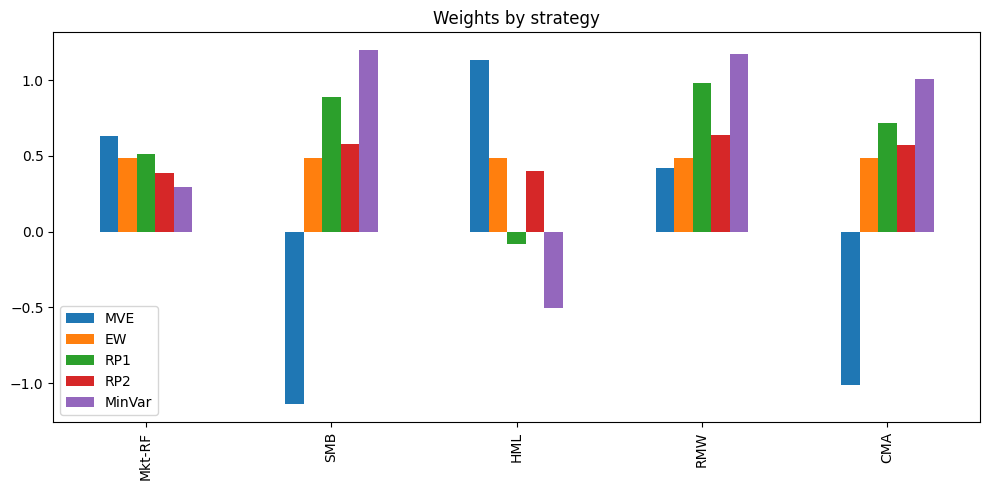

In [40]:
N = len(factors)
Re = df[factors]          # returns in percent

sigma_vec = Re.std()      # standard deviations (used in RP rules)

def mve_weights(mu, Sigma):
    """Return unit-normalised MVE weights given mu and Sigma."""
    raw = np.linalg.inv(Sigma) @ mu
    return raw / raw.sum()

def leverage_to_vol(w, Sigma, target_ann_vol):
    """Scale w so annualised portfolio vol equals target_ann_vol (in percent)."""
    port_vol = (12 * w @ Sigma @ w) ** 0.5
    return w * target_ann_vol / port_vol

target_vol = (Re['Mkt-RF'].var() * 12) ** 0.5   # market annualised vol

# Rule 1 — Equal Weight
w_ew   = np.ones((N,)) / N
W_ew   = leverage_to_vol(w_ew,   CovRe, target_vol)

# Rule 2 — RP1 (estimated covariance, vol-proportional mu)
w_rp1  = np.linalg.inv(CovRe) @ sigma_vec
W_rp1  = leverage_to_vol(w_rp1,  CovRe, target_vol)

# Rule 3 — RP2 (diagonal covariance, inverse-vol weights)
w_rp2  = 1 / sigma_vec
W_rp2  = leverage_to_vol(w_rp2,  CovRe, target_vol)

# Rule 4 — Minimum Variance
w_minvar = np.linalg.inv(CovRe) @ np.ones((N,))
W_minvar = leverage_to_vol(w_minvar, CovRe, target_vol)

# Collect in a DataFrame for comparison
Weights = pd.DataFrame({
    'MVE':    W_mve,
    'EW':     W_ew,
    'RP1':    W_rp1,
    'RP2':    W_rp2,
    'MinVar': W_minvar,
}, index=factors)

print(Weights.round(3))
Weights.plot.bar(figsize=(10,5), title='Weights by strategy')
plt.tight_layout()

**Exercise 5 — In-sample comparison**

Compute the **full-sample** annualised Sharpe Ratio for all five strategies (MVE, EW, RP1, RP2, MinVar) plus the market portfolio (`Mkt-RF`) as a benchmark.

Report them in a table and plot a bar chart.

Then discuss:
1. Which strategy performs best in-sample? Is this surprising?
2. What is the main problem with comparing in-sample Sharpe Ratios across strategies?
3. Why is in-sample performance a biased measure when the weights were estimated from the same data?

        Sharpe Ratio
MVE         1.587621
EW          0.600507
RP1         0.400315
RP2         0.520329
MinVar      0.017616
MKT         0.686509


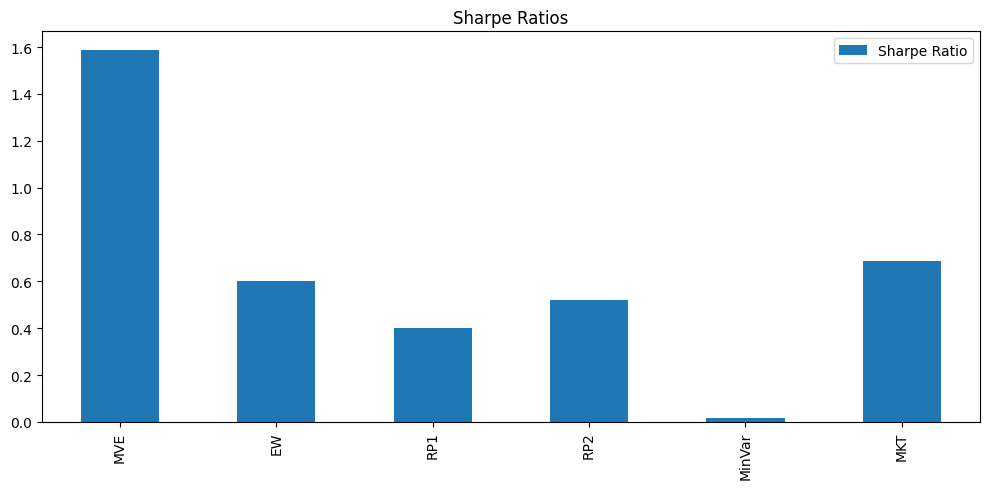

In [41]:
# your code here

sharpe_MVE = sharpe(W_mve, ERe, CovRe)
sharpe_EW = sharpe(W_ew, ERe, CovRe)
sharpe_RP1 = sharpe(W_rp1, ERe, CovRe)
sharpe_RP2 = sharpe(W_rp2, ERe, CovRe)
sharpe_MinVar = sharpe(W_minvar, ERe, CovRe)

MKT_ER_ann = df['Mkt-RF'].mean() * 12
MKT_vol_ann = df['Mkt-RF'].std() * 12**0.5
sharpe_MKT = MKT_ER_ann / MKT_vol_ann

# table
labels = ['MVE', 'EW', 'RP1', 'RP2', 'MinVar', 'MKT']
sharpes = [sharpe_MVE, sharpe_EW, sharpe_RP1, sharpe_RP2, sharpe_MinVar, sharpe_MKT]
sharpe_table = pd.DataFrame({"Sharpe Ratio": sharpes}, index=labels)
print(sharpe_table)

# chart
sharpe_table.plot.bar(figsize=(10,5), title='Sharpe Ratios')
plt.tight_layout()

1.   **Which strategy performs best in-sample? Is this surprising?**

The MVE portfolio performs the best. This is not surprising because we structured it to optimize the Sharpe Ratio.

2.   **What is the main problem with comparing in-sample Sharpe Ratios across strategies?**

We introduce bias from only using in-sample data. In addition, the MVE will always have the highest Sharpe Ratio.

3.   **Why is in-sample performance a biased measure when the weights were estimated from the same data?**

You don't know if your data will hold out of sample. You may be overfitting.

**Exercise 6 — Rolling out-of-sample evaluation**

In-sample performance is optimistic because the weights were estimated from the same data used to evaluate them.  
A fairer test: **estimate weights using only past data, then evaluate on the next month**.

We split the sample at the midpoint: the first half is the initial estimation window; then we expand it one month at a time.

The code below implements this for the MVE strategy. Extend it for all four alternative strategies.

```python
import numpy as np
Rp = pd.DataFrame([], index=[], columns=[], dtype=float)
Re = df[factors]
start_date = Re.index[len(Re) // 2]   # midpoint of sample

for date in Re[start_date:].index:
    # Estimation sample: everything strictly before this month
    est = Re[:date - pd.DateOffset(months=1)]
    ERe_t  = est.mean()
    CovRe_t = est.cov()
    target_vol = (est['Mkt-RF'].var() * 12) ** 0.5

    # MVE
    w_mve_t = mve_weights(ERe_t.values, CovRe_t.values)
    W_mve_t = leverage_to_vol(w_mve_t, CovRe_t.values, target_vol)
    Rp.at[date, 'MVE'] = W_mve_t @ Re.loc[date, factors]

    # --- add EW, RP1, RP2, MinVar below ---
```

Notes:
- `mve_weights` and `leverage_to_vol` are the helper functions from Exercise 4.
- The leverage target is re-estimated each month from the expanding window.
- Store each strategy's return for that month in `Rp`.

In [42]:
# your code here
import numpy as np
Rp = pd.DataFrame([], index=[], columns=[], dtype=float)
Re = df[factors]
start_date = Re.index[len(Re) // 2]   # midpoint of sample

for date in Re[start_date:].index:
    # Estimation sample: everything strictly before this month
    est = Re[:date - pd.DateOffset(months=1)]
    ERe_t  = est.mean()
    CovRe_t = est.cov()
    target_vol = (est['Mkt-RF'].var() * 12) ** 0.5
    sigma_vec_t = est.std()

    # MVE
    w_mve_t = mve_weights(ERe_t.values, CovRe_t.values)
    W_mve_t = leverage_to_vol(w_mve_t, CovRe_t.values, target_vol)
    Rp.at[date, 'MVE'] = W_mve_t @ Re.loc[date, factors]

    # --- add EW, RP1, RP2, MinVar below ---

    # EW
    w_ew_t = np.ones((N,)) / N
    W_ew_t = leverage_to_vol(w_ew_t, CovRe_t.values, target_vol)
    Rp.at[date, 'EW'] = W_ew_t @ Re.loc[date, factors]

    # RP1
    w_RP1_t = np.linalg.inv(CovRe_t) @ sigma_vec_t
    W_RP1_t = leverage_to_vol(w_RP1_t, CovRe_t, target_vol)
    Rp.at[date, 'RP1'] = W_RP1_t @ Re.loc[date, factors]

    # RP2
    w_RP2_t = 1 / sigma_vec_t
    W_RP2_t = leverage_to_vol(w_RP2_t, CovRe_t, target_vol)
    Rp.at[date, 'RP2'] = W_RP2_t @ Re.loc[date, factors]

    # MinVar
    w_MinVar_t = np.linalg.inv(CovRe_t) @ np.ones((N,))
    W_MinVar_t = leverage_to_vol(w_MinVar_t, CovRe_t, target_vol)
    Rp.at[date, 'MinVar'] = W_MinVar_t @ Re.loc[date, factors]

**Exercise 7 — Out-of-sample performance analysis**

Using the rolling returns in `Rp`, compute for each strategy:
- Annualised expected excess return: $12 \times \bar{R}^e_p$
- Annualised volatility: $\sqrt{12} \times \sigma(R^e_p)$
- Sharpe Ratio: ratio of the two

Also add the market factor (`Mkt-RF`) evaluated over the same out-of-sample period as a benchmark.

Report everything in a table and plot the cumulative returns of each strategy.

Then discuss:
1. Is there a clear winner? Can you conclude one strategy is better?
2. What statistical test could you use to check whether differences in expected returns are significant? Apply it.
3. Even if expected returns differ significantly, what other sources of return differences might not interest a long-only investor? (Hint: think about what the factor portfolios are.)
4. What would you want to see beyond Sharpe Ratios to fully evaluate these strategies?

               ER        vol        SR
MVE      9.903860  11.149149  0.888306
EW       1.731138  13.128242  0.131864
RP1    -12.351353  17.824605 -0.692938
RP2     -2.234376  14.033352 -0.159219
MinVar -21.966581  19.433714 -1.130334
MKT     14.788000  12.720718  1.162513


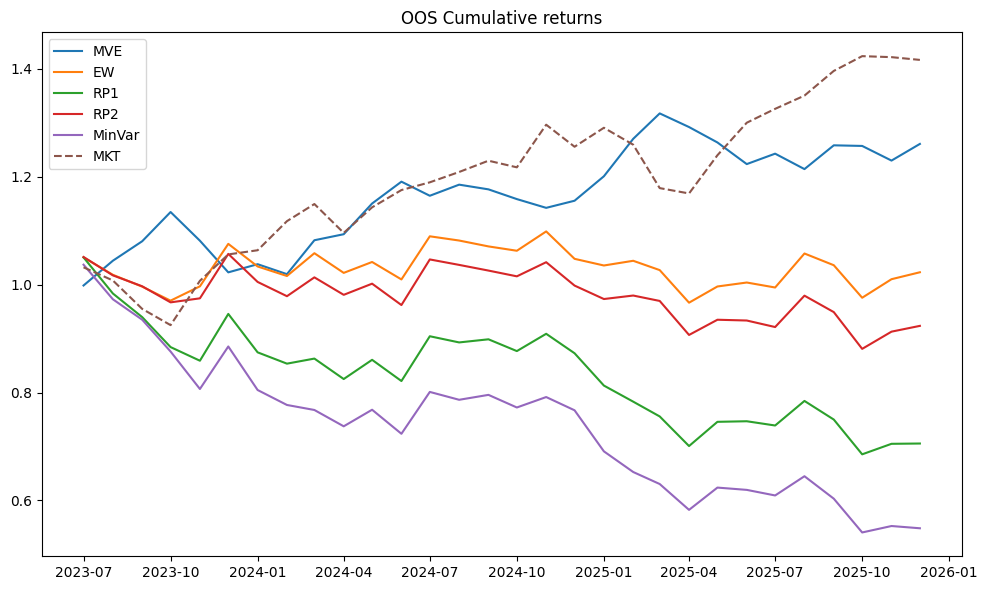

In [43]:
# your code here

sharpe_table = pd.DataFrame([], index=[], columns=[], dtype=float)

for strategy in Rp.columns:
  ERe_ann = 12 * Rp[strategy].mean()
  vol_ann = 12**0.5 * Rp[strategy].std()
  SR_ann = ERe_ann / vol_ann

  sharpe_table.at[strategy, 'ER'] = ERe_ann
  sharpe_table.at[strategy, 'vol'] = vol_ann
  sharpe_table.at[strategy, 'SR'] = SR_ann

OOS_MKT = df['Mkt-RF'].loc[start_date:]

MKT_ER_ann = OOS_MKT.mean() * 12
MKT_vol_ann = OOS_MKT.std() * 12**0.5
MKT_SR_ann = MKT_ER_ann / MKT_vol_ann
sharpe_table.at['MKT', 'ER'] = MKT_ER_ann
sharpe_table.at['MKT', 'vol'] = MKT_vol_ann
sharpe_table.at['MKT', 'SR'] = MKT_SR_ann

print(sharpe_table)


plot, ax = plt.subplots(figsize=(10,6))

cum_Rp = (1 + Rp/100).cumprod()

for col in cum_Rp.columns:
    ax.plot(cum_Rp[col], label=col)

cum_MKT = (1 + OOS_MKT/100).cumprod()
ax.plot(cum_MKT, linestyle='--', label='MKT')
ax.legend()
ax.set_title('OOS Cumulative returns')
plt.tight_layout()
plt.show()

1. Is there a clear winner? Can you conclude one strategy is better?

> Seems like Mkt-RF is the clear winner. Within the strategies, MVE is the best. It has the highest Sharpe Ratio.


2. What statistical test could you use to check whether differences in expected returns are significant? Apply it.

> We can use a hypothesis test. See below.

3. Even if expected returns differ significantly, what other sources of return differences might not interest a long-only investor? (Hint: think about what the factor portfolios are.)

> The factor portfolios are self financed with a long part and a short part. This is not suitable for a long only investor.

4. What would you want to see beyond Sharpe Ratios to fully evaluate these strategies?

> Some are the betas of the portfolio and if the strategy remains stable.

In [44]:
import scipy.stats as stats

t_stat, p_two_sided = stats.ttest_rel(Rp['MVE'], Rp['EW'])
t_stat, p_two_sided

(np.float64(0.6401715694687511), np.float64(0.5270870789456072))